#EE452 Computer Vision: Assignment 2
Generative Adversarial Network (GAN) Application
# Owais Aijaz 07610

# Question 1: DCGANs and more

## References:

https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

https://github.com/lucidrains/stylegan2-pytorch

## Setup:

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## 1.1

In [2]:
import kagglehub

#Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.82G/1.82G [00:23<00:00, 84.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2


In [3]:
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_train /content/

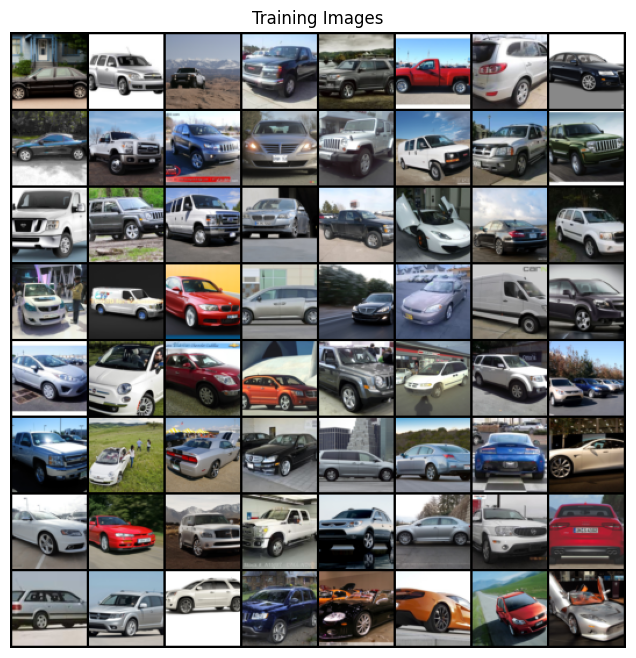

In [4]:
#Resizing the images to 64x64

path = '/content/cars_train'
dataset = dset.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
#Creating the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Plotting some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

I'm preprocessing the cars dataset, specifically resizing them to 64x64 pixels for training. I'm applying a series of transformations like resizing, cropping, converting to tensor format, and normalizing the pixel values.

## 1.2

In [10]:
#Custom weights initialization for both discriminator and generator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
#Discriminator Architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #Input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #State size: 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            #State size: 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            #State size: 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            #State size: 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(  (main): Sequential(    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)    (1): LeakyReLU(negative_slope=0.2, inplace=True)    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)    (4): LeakyReLU(negative_slope=0.2, inplace=True)    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)    (7): LeakyReLU(negative_slope=0.2, inplace=True)    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)    (10): LeakyReLU(negative_slope=0.2, inplace=True)    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)    (12): Sigmoid()  ))

**Justification:**

The architecture is designed to process 64x64 images by progressively downsampling through convolutional layers with increasing feature maps (64, 128, 256, 512). Each layer uses LeakyReLU activation to address the vanishing gradient problem and Batch Normalization to stabilize learning. At last we have Sigmoid activation ensuring output in the [0, 1] range for binary classification of real or fake inputs.

## 1.3

In [11]:
#Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #Input is Z, going into a convolution
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #State size: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #State size: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #State size: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #State size: 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            #State size: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


**Justification:**

The generator starts with a latent vector of size 100, which is progressively transformed into a 64x64 image through transposed convolution layers. The size of starting vector (Z) influences the generator's ability to capture variation in the generated images. Smaller Z, reduces the model's capacity to encode diverse features. Larger Z, enables the generator to model more complex patterns and generate diverse outputs. The choice of Z-dimension reflects a trade-off between the model's expressive power and training complexity.

## 1.4

In [ ]:
# Hyperparameters
batch_size = 128  # Batch size during training
image_size = 64   # Spatial size of training images.
nc = 3            # Number of channels in the training images. For color images this is 3
Z = 100           # Size of z latent vector (i.e. size of generator input)
ngf = 64          # Size of feature maps in generator
ndf = 64          # Size of feature maps in discriminator
num_epochs = 50    # Number of training epochs
lr = 0.0002       # Learning rate for optimizers
beta1 = 0.5       # Beta1 hyperparameter for Adam optimizers

# Initialize the loss function (Binary Cross Entropy)
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, Z, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        #For Discriminator
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # For Generator
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...[0/5][0/64]	Loss_D: 1.6664	Loss_G: 4.4424	D(x): 0.4172	D(G(z)): 0.4164 / 0.0159[0/5][50/64]	Loss_D: 1.8752	Loss_G: 17.5385	D(x): 0.4778	D(G(z)): 0.0000 / 0.0000[1/5][0/64]	Loss_D: 0.1999	Loss_G: 14.9222	D(x): 0.8876	D(G(z)): 0.0001 / 0.0000[1/5][50/64]	Loss_D: 1.1596	Loss_G: 3.9754	D(x): 0.4941	D(G(z)): 0.0335 / 0.0433[2/5][0/64]	Loss_D: 0.6740	Loss_G: 8.0636	D(x): 0.8846	D(G(z)): 0.3652 / 0.0008[2/5][50/64]	Loss_D: 0.8903	Loss_G: 8.2174	D(x): 0.9554	D(G(z)): 0.5184 / 0.0010[3/5][0/64]	Loss_D: 0.3128	Loss_G: 4.5075	D(x): 0.8333	D(G(z)): 0.1023 / 0.0153[3/5][50/64]	Loss_D: 0.5449	Loss_G: 3.4782	D(x): 0.8221	D(G(z)): 0.2529 / 0.0401[4/5][0/64]	Loss_D: 0.7340	Loss_G: 4.6103	D(x): 0.9270	D(G(z)): 0.4343 / 0.0153[4/5][50/64]	Loss_D: 0.4034	Loss_G: 5.1461	D(x): 0.7680	D(G(z)): 0.0384 / 0.0125[5/5][0/64]	Loss_D: 0.4292	Loss_G: 4.1072	D(x): 0.7792	D(G(z)): 0.1038 / 0.0279[5/5][50/64]	Loss_D: 0.4153	Loss_G: 3.8556	D(x): 0.7300	D(G(z)): 0.0370 / 0.0257[6/5][0/64]	Loss_D:

I trained for 50 epochs. Printing losses for each.

## 1.5

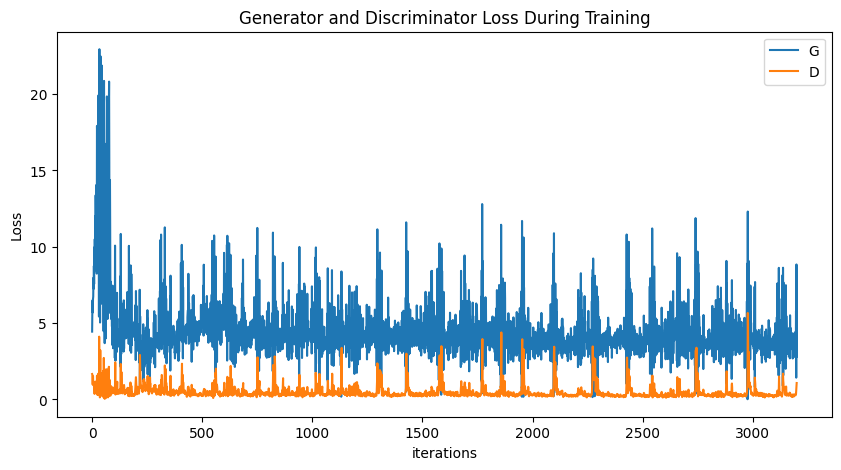

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

I don't see anything unusual. The loss values show the typical progression of a GAN training loop. In the early stages, the discriminator easily distinguishes real from fake images, resulting in high generator loss (indicating poor image quality). As training progresses, the discriminator becomes more confident, and the generator improves, creating more realistic images that the discriminator finds harder to distinguish. The fluctuations in the losses reflect this adversarial process, with the generator gradually improving its ability to fool the discriminator over time.

## 1.6

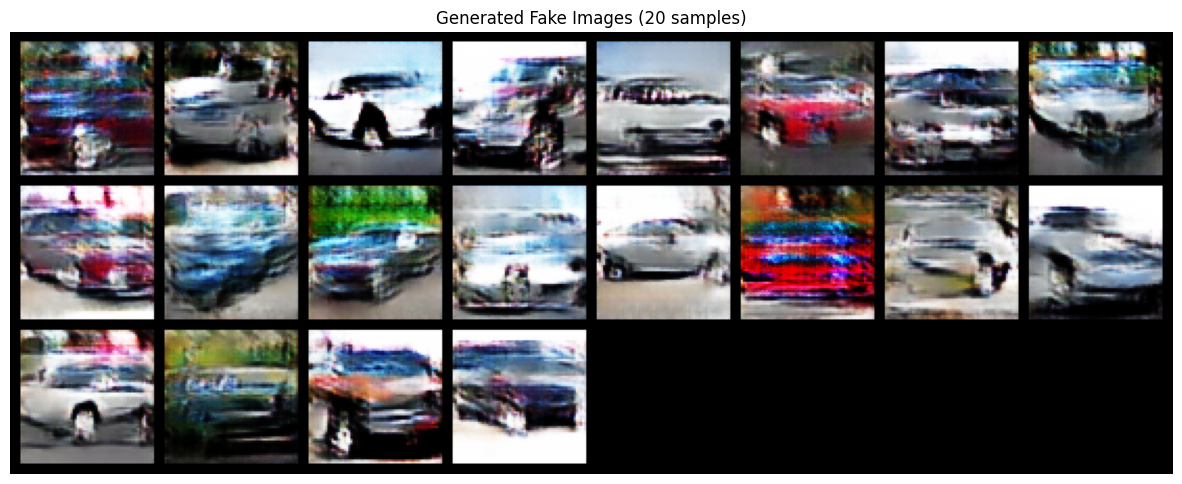

In [ ]:
def generate_samples(n, generator, device, latent_dim=100):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        # Generate random latent vectors
        noise = torch.randn(n, latent_dim, 1, 1, device=device)

        # Generate images from the latent vectors
        fake_images = generator(noise)

        return fake_images

# Generating 20 images
fake_images = generate_samples(20, netG, device)

# Plot the generated fake images
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title(f"Generated Fake Images (20 samples)")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=5, normalize=True).cpu(), (1, 2, 0)))
plt.show()

I think it looks pretty good. At first glance, it looks like a car (almost) :')

## 1.7

### Part a:

I think we can use a pre-trained VGG-16 network in a GAN, typically as part of the discriminator to as it's a classifier. However, using VGG-16 won't change the fact that the network is still a DCGAN (Deep Convolutional GAN). The architecture of DCGAN is defined by the specific types of layers (convolutional, batch normalization, etc.) in both the generator and discriminator, not by the exact model architecture (like VGG-16). So, the model would still be classified as a DCGAN, but VGG-16 could be incorporated in the discriminator, potentially improving its ability to distinguish between real and fake images due to its pre-trained feature extraction capabilities.

### Part b:

VGG-16 is a discriminative network, as it is trained to classify images and distinguish between different categories (such as real vs. fake in the case of a discriminator). It is designed to output a probability distribution over classes (discriminating between them). VGG-16 cannot be used as a generator in a GAN because the generator's goal is to produce new, synthetic data (images), whereas a discriminator like VGG-16 is meant to differentiate between real and fake data. The generator requires a different architecture that can map a random noise vector to a realistic output, which VGG-16 is not designed to do.

### Part c:

In [13]:
from torchvision import models

class VGG16_Discriminator(nn.Module):
    def __init__(self):
        super(VGG16_Discriminator, self).__init__()
        # Load pre-trained VGG-16 model
        vgg16 = models.vgg16(pretrained=True)

        # Remove the classifier layers (fully connected layers)
        self.features = vgg16.features

        # Add a Global Average Pooling layer to reduce dimensions
        self.pool = nn.AdaptiveAvgPool2d(1)  # Output size 1x1

        # Final fully connected layer (output size = 1 for binary classification)
        self.fc = nn.Linear(512, 1)

        # Sigmoid activation to output probability
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass through convolutional layers
        x = self.features(x)

        # Global average pooling to reduce the spatial dimensions
        x = self.pool(x)

        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)

        # Final fully connected layer and sigmoid
        x = self.fc(x)
        x = self.sigmoid(x)

        return x

In [14]:
# Initialize models
generator = Generator().to(device)
discriminator = VGG16_Discriminator().to(device)

# Initialize weights for generator and discriminator
generator.apply(weights_init)
discriminator.apply(weights_init)

VGG16_Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddi

Epoch [1/50] | D Loss: 1.3584821224212646 | G Loss: 0.6247962117195129
Epoch [2/50] | D Loss: 1.5241803228855133 | G Loss: 0.6567807197570801
Epoch [3/50] | D Loss: 1.3865131735801697 | G Loss: 0.6798253059387207
Epoch [4/50] | D Loss: 1.3864261507987976 | G Loss: 0.7285487055778503
Epoch [5/50] | D Loss: 1.4178874790668488 | G Loss: 0.7149107456207275
Epoch [6/50] | D Loss: 1.3818498253822327 | G Loss: 0.6966229677200317
Epoch [7/50] | D Loss: 1.3622450828552246 | G Loss: 0.745733916759491
Epoch [8/50] | D Loss: 1.332331120967865 | G Loss: 0.7110766172409058
Epoch [9/50] | D Loss: 1.3003284931182861 | G Loss: 0.7770756483078003
Epoch [10/50] | D Loss: 1.359128624200821 | G Loss: 1.255713701248169


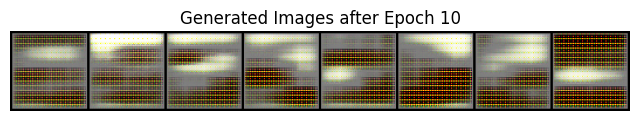

Epoch [11/50] | D Loss: 1.29114431142807 | G Loss: 0.9219868779182434
Epoch [12/50] | D Loss: 1.3137732148170471 | G Loss: 1.078605055809021
Epoch [13/50] | D Loss: 1.5216479897499084 | G Loss: 0.6816667914390564
Epoch [14/50] | D Loss: 1.121000349521637 | G Loss: 0.993794858455658
Epoch [15/50] | D Loss: 1.0591556131839752 | G Loss: 1.4882831573486328
Epoch [16/50] | D Loss: 1.4301972687244415 | G Loss: 2.1795544624328613
Epoch [17/50] | D Loss: 0.8613075315952301 | G Loss: 1.6778913736343384
Epoch [18/50] | D Loss: 0.8107796311378479 | G Loss: 1.6733276844024658
Epoch [19/50] | D Loss: 0.8912220001220703 | G Loss: 1.6359577178955078
Epoch [20/50] | D Loss: 0.5623497813940048 | G Loss: 2.582782030105591


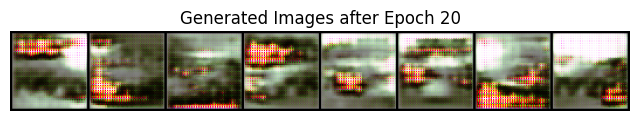

Epoch [21/50] | D Loss: 1.0626702308654785 | G Loss: 1.1360334157943726
Epoch [22/50] | D Loss: 0.7731976807117462 | G Loss: 1.5022928714752197
Epoch [23/50] | D Loss: 0.6904172152280807 | G Loss: 2.048159599304199
Epoch [24/50] | D Loss: 0.6468550488352776 | G Loss: 1.8455013036727905
Epoch [25/50] | D Loss: 0.41781751811504364 | G Loss: 4.41118860244751
Epoch [26/50] | D Loss: 0.5364671498537064 | G Loss: 3.066915512084961
Epoch [27/50] | D Loss: 0.5467032343149185 | G Loss: 2.2351958751678467
Epoch [28/50] | D Loss: 0.28614006005227566 | G Loss: 3.584345579147339
Epoch [29/50] | D Loss: 0.25983714312314987 | G Loss: 4.627355098724365
Epoch [30/50] | D Loss: 0.11243778839707375 | G Loss: 4.728321075439453


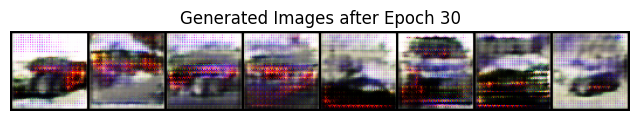

Epoch [31/50] | D Loss: 0.24994222074747086 | G Loss: 5.7935028076171875
Epoch [32/50] | D Loss: 0.11605903692543507 | G Loss: 6.570311069488525
Epoch [33/50] | D Loss: 0.2670142203569412 | G Loss: 5.0608229637146
Epoch [34/50] | D Loss: 0.5000354200601578 | G Loss: 2.8988730907440186
Epoch [35/50] | D Loss: 0.22903328388929367 | G Loss: 6.246060848236084
Epoch [36/50] | D Loss: 0.1253870166838169 | G Loss: 6.628983497619629
Epoch [37/50] | D Loss: 0.15108176693320274 | G Loss: 6.0126166343688965
Epoch [38/50] | D Loss: 0.22301902156323195 | G Loss: 7.865140438079834
Epoch [39/50] | D Loss: 0.07771583087742329 | G Loss: 7.534448146820068
Epoch [40/50] | D Loss: 0.05292969848960638 | G Loss: 6.844029426574707


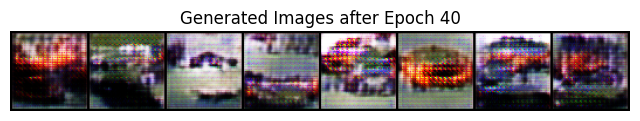

Epoch [41/50] | D Loss: 0.0651740562170744 | G Loss: 6.907580852508545
Epoch [42/50] | D Loss: 0.11871534213423729 | G Loss: 9.166111946105957
Epoch [43/50] | D Loss: 0.1568404585123062 | G Loss: 6.364091396331787
Epoch [44/50] | D Loss: 0.16695910692214966 | G Loss: 8.038777351379395
Epoch [45/50] | D Loss: 0.028832504525780678 | G Loss: 8.078230857849121
Epoch [46/50] | D Loss: 0.10978145524859428 | G Loss: 7.70269775390625
Epoch [47/50] | D Loss: 0.08984902687370777 | G Loss: 5.754024982452393
Epoch [48/50] | D Loss: 0.1730957143008709 | G Loss: 7.934207439422607
Epoch [49/50] | D Loss: 0.13676153868436813 | G Loss: 8.058701515197754
Epoch [50/50] | D Loss: 0.11925772950053215 | G Loss: 7.332789897918701


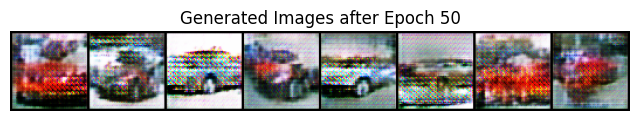

In [15]:
# Binary Cross-Entropy loss
criterion = nn.BCELoss()

# Optimizers for both networks
lr = 0.0002
beta1 = 0.5
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Labels for real and fake images
real_label = 1
fake_label = 0

# Training loop
for epoch in range(50):  # Training for 50 epochs as the DCGAN
    for i, (data, _) in enumerate(dataloader, 0):
        # Update discriminator with real images
        discriminator.zero_grad()
        real_images = data.to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float32)

        output = discriminator(real_images).view(-1)
        err_d_real = criterion(output, label)
        err_d_real.backward()

        # Generate fake images
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake_images = generator(noise)
        label.fill_(fake_label)

        output = discriminator(fake_images.detach()).view(-1)
        err_d_fake = criterion(output, label)
        err_d_fake.backward()

        optimizer_d.step()

        # Update generator
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake_images).view(-1)
        err_g = criterion(output, label)
        err_g.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/50] | D Loss: {err_d_real.item() + err_d_fake.item()} | G Loss: {err_g.item()}')

    # Plot generated images after ten epoch
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            fake_images = generator(noise).detach().cpu()
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title(f"Generated Images after Epoch {epoch+1}")
        plt.imshow(np.transpose(vutils.make_grid(fake_images[:8], padding=2, normalize=True).cpu(), (1,2,0)))
        plt.show()

**Comparison:**

VGG-16 as Discriminator is better than DCGAN's default discriminator in terms of performance. The Discriminator Loss and Generator Loss for VGG-16 are much lower (better) than those for DCGAN, meaning that the model learns more effectively and generates higher-quality images. VGG-16's pre-trained features make it a more stable discriminator, leading to smoother training and more realistic generated images.

DCGAN performs reasonably well for basic GAN tasks, but VGG-16 improves the performance substantially when used as the discriminator. The generator benefits from the more powerful discriminator, leading to better loss reduction during training. However, I personally like the DCGAN generated images more, as the standard discriminator is less strict in that one.

## 1.8 (Bonus)

In [16]:
!pip install stylegan2_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 67.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.1 MB/s eta 0:00:00
   ━━━━

In [18]:
import os
from PIL import Image
import torchvision.transforms as transforms

# Define paths for input and output
input_path = '/content/cars_train/cars_train'  # Original dataset
output_path = '/content/cars_data_sgan'   # New path for resized images

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Define the transformation: resizing to 128x128
transform = transforms.Compose([
    transforms.Resize(128),         # Resize to 128x128
    transforms.CenterCrop(128),     # Center crop to make sure it's square
    transforms.ToTensor(),          # Convert image to tensor
])

# Counter for keeping track of how many images we processed
count = 0

# Loop through the original dataset and resize each image
for img_name in os.listdir(input_path):
    img_path = os.path.join(input_path, img_name)

    # Only process image files (skip non-image files)
    if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    try:
        # Open the image
        with Image.open(img_path) as img:
            # Apply the transformation (resize and crop)
            img_tensor = transform(img)

            # Convert tensor back to PIL Image for saving
            img_resized = transforms.ToPILImage()(img_tensor)

            # Save the resized image to the new folder
            resized_img_path = os.path.join(output_path, img_name)
            img_resized.save(resized_img_path)
            count += 1

    except Exception as e:
        print(f"Error processing {img_name}: {e}")

print(f"Processed {count} images. Resized images saved to {output_path}")

Processed 8144 images. Resized images saved to /content/cars_data_sgan


In [20]:
!stylegan2_pytorch --data /content/cars_data_sgan \
    --batch-size 3 \
    --gradient-accumulate-every 5 \
    --network-capacity 16

default</content/cars_data_sgan>:   0% 0/150000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
default</content/cars_data_sgan>:   0% 50/150000 [01:17<64:48:44,  1.56s/it]G: 12.29 | D: 0.34 | GP: 0.77
default</content/cars_data_sgan>:   0% 100/150000 [02:28<61:45:08,  1.48s/it]G: -1.95 | D: 1.21 | GP: 0.46
default</content/cars_data_sgan>:   0% 150/150000 [03:42<61:51:32,  1.49s/it]G: -0.08 | D: 2.15 | GP: 0.03
default</content/cars_data_sgan>:   0% 200/150000 [04:53<61:04:36,  1.47s/it]G: 311.84 | D: 0.03 | GP: 129.36
default</content/cars_data_sgan>:   0% 250/150000 [06:08<61:14:53,  1.47s/it]G: 15.45 | D: 4.29 | GP: 3.56
default</content/cars_data_sgan>:

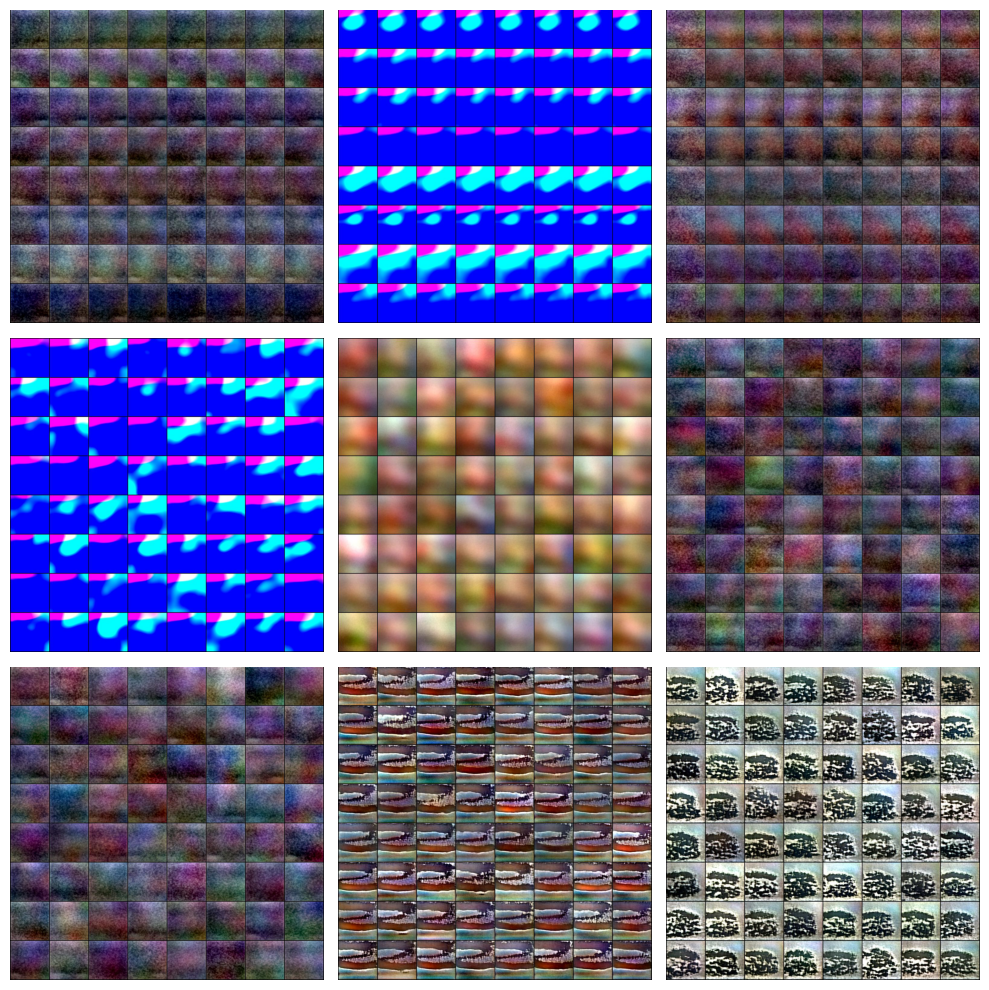

In [22]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the folder containing images
sganresults = '/content/results/default'

# Get the list of images in the folder
image_files = os.listdir(sganresults)

# Filter out only the image files (optional, if there are other types of files in the directory)
image_files = [file for file in image_files if file.endswith(('jpg', 'png', 'jpeg'))]

# Display images
plt.figure(figsize=(10, 10))  # Set the figure size
for idx, image_file in enumerate(image_files):
    img = mpimg.imread(os.path.join(sganresults, image_file))
    plt.subplot(3, 3, idx + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

I used StyleGan2, which supposedly is one of the SOTA models for image generation. I didn't make it from scratch and used a GitHub repo instead. It was taking painfully long to train though. I was only able to process about 2000 images and hence the resulting images aren't good. I'm pretty sure we can get some really good results though if we had the computing power.

# Question 2: Read up folks! More GANS

## 2.1

**Suitable GAN: SRGAN (Super-Resolution GAN)** \\
SRGAN is specifically designed to generate high-resolution images from low-resolution inputs. In this scenario, the student has applied median blurring to the images, resulting in a loss of details and resolution. SRGAN can be used to restore the original high-definition quality by generating high-resolution images that retain the fine details like edges, textures, and finer patterns in the images.

## 2.2

**Suitable GAN: Style Transfer GAN (or Conditional GANs with Style Transfer capabilities)** \\
Style Transfer GANs are used to modify specific visual attributes in an image while maintaining the underlying content (e.g., preserving the face’s structure but changing attributes like hair color or facial features). Since the digital media company wants to modify only specific features of the face while keeping other aspects (like the background and facial identity) intact, a Style Transfer GAN is ideal for this task, allowing targeted adjustments with minimal distortion to other parts of the image.

## 2.3

**Suitable GAN: CycleGAN (Cycle-Consistent GAN)** \\
CycleGAN is ideal for unpaired image-to-image translation tasks. Since the interns don’t have paired images of pandas and bears, CycleGAN can be used to learn a mapping between two domains (panda images and bear images) without requiring corresponding pairs. The model can generate realistic images where the bear’s skin texture is changed to that of a panda, even if no paired images are available for training.

## 2.4

**Suitable GAN: SRGAN (Super-Resolution GAN)** \\
SRGAN is designed to improve the resolution of low-quality images, making it the best choice for satellite imaging tasks that require high-resolution images from low-resolution counterparts. For satellite imagery, generating high-quality, geographically accurate images from low-resolution images would benefit from SRGAN’s ability to capture fine details (such as roads and rivers) and produce a sharper, more detailed output.

## 2.5

**Suitable GAN: EnhanceGAN** \\
EnhanceGAN is specifically designed for enhancing the quality of images in low-light conditions. It helps in increasing brightness, reducing noise, and retaining image details, which are crucial for wildlife photography in low-light scenarios. The EnhanceGAN model can be trained to improve the visual quality of images captured under poor lighting while preserving the textures and details of animals and the environment.

## 2.6

**Suitable GAN: Style Transfer GAN** \\
Style Transfer GANs are designed to transfer the artistic style of one image (e.g., a painting by Van Gogh) onto the content of another image (e.g., a family photo). In this case, the daughter can use a Style Transfer GAN to take the texture and visual style of Van Gogh’s paintings and apply it to her family photos. She would need a dataset of high-quality images of Van Gogh's paintings to represent the artistic style. The model can be trained on these paintings while using the family photos as the content images. During training, the GAN learns to preserve the content of the family photos while transferring the brush strokes, color schemes, and texture from the Van Gogh paintings onto the photos.